In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 创建单层决策树的数据集
def loadSimpData():
    datMat = np.matrix([
        [ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [22]:
# 数据可视化
def showDataSet(dataMat, labelMat):
    data_plus = []  # 正样本
    data_minus = []  # 负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)  # 转换为numpy矩阵
    data_minus_np = np.array(data_minus)  # 转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])  # 正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1])  # 负样本散点图
    plt.show()

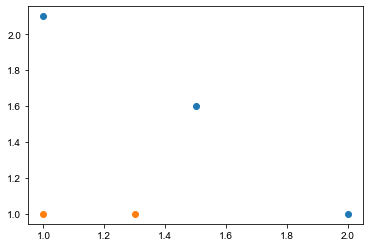

In [34]:
datMat,labelMat = loadSimpData()
showDataSet(datMat,labelMat)

In [3]:
"""
Parameters:
    dataMatrix - 数据矩阵
    dimen - 第dimen列，也就是第几个特征
    threshVal - 阈值
    threshIneq - 标志
Returns:
    retArray - 分类结果
"""
# 单层决策树分类函数
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0],1))         #初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0   #如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0    #如果大于阈值,则赋值为-1
    return retArray

In [4]:
"""
Parameters:
    dataArr - 数据矩阵
    classLabels - 数据标签
    D - 样本权重
Returns:
    bestStump - 最佳单层决策树信息
    minError - 最小误差
    bestClasEst - 最佳的分类结果
"""
# 找到数据集上最佳的单层决策树
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    #最小误差初始化为正无穷大
    minError = float('inf')  
    #遍历所有特征
    for i in range(n):       
        #找到特征中最小的值和最大值
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max() 
         #计算步长
        stepSize = (rangeMax - rangeMin) / numSteps                            
        for j in range(-1, int(numSteps) + 1):
            #大于和小于的情况，均遍历。lt:less than，gt:greater than
            for inequal in ['lt', 'gt']:     
                #计算阈值
                threshVal = (rangeMin + float(j) * stepSize) 
                #计算分类结果
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                #初始化误差矩阵
                errArr = np.mat(np.ones((m,1)))    
                #分类正确的,赋值为0
                errArr[predictedVals == labelMat] = 0 
                #计算误差
                weightedError = D.T * errArr                                    
                print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                #找到误差最小的分类方式
                if weightedError < minError:                                    
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst


In [35]:
dataArr,classLabels = loadSimpData()
D = np.mat(np.ones((5, 1)) / 5)
bestStump,minError,bestClasEst = buildStump(dataArr,classLabels,D)
print('bestStump:\n', bestStump)
print('minError:\n', minError)
print('bestClasEst:\n', bestClasEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

In [6]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)                                       #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)  #构建单层决策树
        print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))    #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha                                        #存储弱学习算法权重
        weakClassArr.append(bestStump)                                    #存储单层决策树
        print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst) #计算e的指数项
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()                                                   #根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))#计算误差
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate)
        if errorRate == 0.0: break                                        #误差为0，退出循环
    return weakClassArr, aggClassEst

In [8]:
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
print(weakClassArr)
print(aggClassEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

In [9]:
# AdaBoost分类函数
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):  # 遍历所有分类器，进行分类
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'],
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

### 在马疝病数据集上应用Adaboost分类器

In [11]:
def loadDataSet(fileName):
    numFeat = len((open(fileName).readline().split('\t')))
    dataMat = [];
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [12]:
dataArr, LabelArr = loadDataSet('horseColicTraining2.txt')
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, LabelArr)
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
print(weakClassArr)
predictions = adaClassify(dataArr, weakClassArr)
errArr = np.mat(np.ones((len(dataArr), 1)))
print('训练集的错误率:%.3f%%' % float(errArr[predictions != np.mat(LabelArr).T].sum() / len(dataArr) * 100))
predictions = adaClassify(testArr, weakClassArr)
errArr = np.mat(np.ones((len(testArr), 1)))
print('测试集的错误率:%.3f%%' % float(errArr[predictions != np.mat(testLabelArr).T].sum() / len(testArr) * 100))

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.405
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.595
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.50, thresh ineq

split: dim 16, thresh 0.00, thresh ineqal: lt, the weighted error is 0.515
split: dim 16, thresh 0.00, thresh ineqal: gt, the weighted error is 0.485
split: dim 16, thresh 0.50, thresh ineqal: lt, the weighted error is 0.515
split: dim 16, thresh 0.50, thresh ineqal: gt, the weighted error is 0.485
split: dim 16, thresh 1.00, thresh ineqal: lt, the weighted error is 0.533
split: dim 16, thresh 1.00, thresh ineqal: gt, the weighted error is 0.467
split: dim 16, thresh 1.50, thresh ineqal: lt, the weighted error is 0.533
split: dim 16, thresh 1.50, thresh ineqal: gt, the weighted error is 0.467
split: dim 16, thresh 2.00, thresh ineqal: lt, the weighted error is 0.565
split: dim 16, thresh 2.00, thresh ineqal: gt, the weighted error is 0.435
split: dim 16, thresh 2.50, thresh ineqal: lt, the weighted error is 0.565
split: dim 16, thresh 2.50, thresh ineqal: gt, the weighted error is 0.435
split: dim 16, thresh 3.00, thresh ineqal: lt, the weighted error is 0.579
split: dim 16, thresh 3.0

split: dim 1, thresh 4.20, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 5.00, thresh ineqal: lt, the weighted error is 0.478
split: dim 1, thresh 5.00, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 5.80, thresh ineqal: lt, the weighted error is 0.478
split: dim 1, thresh 5.80, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 6.60, thresh ineqal: lt, the weighted error is 0.478
split: dim 1, thresh 6.60, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 7.40, thresh ineqal: lt, the weighted error is 0.478
split: dim 1, thresh 7.40, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 8.20, thresh ineqal: lt, the weighted error is 0.478
split: dim 1, thresh 8.20, thresh ineqal: gt, the weighted error is 0.522
split: dim 1, thresh 9.00, thresh ineqal: lt, the weighted error is 0.447
split: dim 1, thresh 9.00, thresh ineqal: gt, the weighted error is 0.553
split: dim 2, thresh -4.08, thresh ine

split: dim 19, thresh 1.20, thresh ineqal: lt, the weighted error is 0.551
split: dim 19, thresh 1.20, thresh ineqal: gt, the weighted error is 0.449
split: dim 19, thresh 1.50, thresh ineqal: lt, the weighted error is 0.551
split: dim 19, thresh 1.50, thresh ineqal: gt, the weighted error is 0.449
split: dim 19, thresh 1.80, thresh ineqal: lt, the weighted error is 0.551
split: dim 19, thresh 1.80, thresh ineqal: gt, the weighted error is 0.449
split: dim 19, thresh 2.10, thresh ineqal: lt, the weighted error is 0.552
split: dim 19, thresh 2.10, thresh ineqal: gt, the weighted error is 0.448
split: dim 19, thresh 2.40, thresh ineqal: lt, the weighted error is 0.552
split: dim 19, thresh 2.40, thresh ineqal: gt, the weighted error is 0.448
split: dim 19, thresh 2.70, thresh ineqal: lt, the weighted error is 0.552
split: dim 19, thresh 2.70, thresh ineqal: gt, the weighted error is 0.448
split: dim 19, thresh 3.00, thresh ineqal: lt, the weighted error is 0.526
split: dim 19, thresh 3.0

split: dim 17, thresh 15.00, thresh ineqal: gt, the weighted error is 0.515
split: dim 17, thresh 22.50, thresh ineqal: lt, the weighted error is 0.485
split: dim 17, thresh 22.50, thresh ineqal: gt, the weighted error is 0.515
split: dim 17, thresh 30.00, thresh ineqal: lt, the weighted error is 0.497
split: dim 17, thresh 30.00, thresh ineqal: gt, the weighted error is 0.503
split: dim 17, thresh 37.50, thresh ineqal: lt, the weighted error is 0.478
split: dim 17, thresh 37.50, thresh ineqal: gt, the weighted error is 0.522
split: dim 17, thresh 45.00, thresh ineqal: lt, the weighted error is 0.500
split: dim 17, thresh 45.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 17, thresh 52.50, thresh ineqal: lt, the weighted error is 0.499
split: dim 17, thresh 52.50, thresh ineqal: gt, the weighted error is 0.501
split: dim 17, thresh 60.00, thresh ineqal: lt, the weighted error is 0.490
split: dim 17, thresh 60.00, thresh ineqal: gt, the weighted error is 0.510
split: dim 1

split: dim 11, thresh 0.00, thresh ineqal: lt, the weighted error is 0.445
split: dim 11, thresh 0.00, thresh ineqal: gt, the weighted error is 0.555
split: dim 11, thresh 0.40, thresh ineqal: lt, the weighted error is 0.445
split: dim 11, thresh 0.40, thresh ineqal: gt, the weighted error is 0.555
split: dim 11, thresh 0.80, thresh ineqal: lt, the weighted error is 0.445
split: dim 11, thresh 0.80, thresh ineqal: gt, the weighted error is 0.555
split: dim 11, thresh 1.20, thresh ineqal: lt, the weighted error is 0.518
split: dim 11, thresh 1.20, thresh ineqal: gt, the weighted error is 0.482
split: dim 11, thresh 1.60, thresh ineqal: lt, the weighted error is 0.518
split: dim 11, thresh 1.60, thresh ineqal: gt, the weighted error is 0.482
split: dim 11, thresh 2.00, thresh ineqal: lt, the weighted error is 0.543
split: dim 11, thresh 2.00, thresh ineqal: gt, the weighted error is 0.457
split: dim 11, thresh 2.40, thresh ineqal: lt, the weighted error is 0.543
split: dim 11, thresh 2.4

split: dim 16, thresh 0.50, thresh ineqal: lt, the weighted error is 0.529
split: dim 16, thresh 0.50, thresh ineqal: gt, the weighted error is 0.471
split: dim 16, thresh 1.00, thresh ineqal: lt, the weighted error is 0.532
split: dim 16, thresh 1.00, thresh ineqal: gt, the weighted error is 0.468
split: dim 16, thresh 1.50, thresh ineqal: lt, the weighted error is 0.532
split: dim 16, thresh 1.50, thresh ineqal: gt, the weighted error is 0.468
split: dim 16, thresh 2.00, thresh ineqal: lt, the weighted error is 0.550
split: dim 16, thresh 2.00, thresh ineqal: gt, the weighted error is 0.450
split: dim 16, thresh 2.50, thresh ineqal: lt, the weighted error is 0.550
split: dim 16, thresh 2.50, thresh ineqal: gt, the weighted error is 0.450
split: dim 16, thresh 3.00, thresh ineqal: lt, the weighted error is 0.554
split: dim 16, thresh 3.00, thresh ineqal: gt, the weighted error is 0.446
split: dim 16, thresh 3.50, thresh ineqal: lt, the weighted error is 0.554
split: dim 16, thresh 3.5

split: dim 14, thresh 3.75, thresh ineqal: lt, the weighted error is 0.520
split: dim 14, thresh 3.75, thresh ineqal: gt, the weighted error is 0.480
split: dim 14, thresh 4.50, thresh ineqal: lt, the weighted error is 0.502
split: dim 14, thresh 4.50, thresh ineqal: gt, the weighted error is 0.498
split: dim 14, thresh 5.25, thresh ineqal: lt, the weighted error is 0.500
split: dim 14, thresh 5.25, thresh ineqal: gt, the weighted error is 0.500
split: dim 14, thresh 6.00, thresh ineqal: lt, the weighted error is 0.494
split: dim 14, thresh 6.00, thresh ineqal: gt, the weighted error is 0.506
split: dim 14, thresh 6.75, thresh ineqal: lt, the weighted error is 0.497
split: dim 14, thresh 6.75, thresh ineqal: gt, the weighted error is 0.503
split: dim 14, thresh 7.50, thresh ineqal: lt, the weighted error is 0.467
split: dim 14, thresh 7.50, thresh ineqal: gt, the weighted error is 0.533
split: dim 15, thresh -0.40, thresh ineqal: lt, the weighted error is 0.533
split: dim 15, thresh -0

split: dim 4, thresh 0.00, thresh ineqal: gt, the weighted error is 0.510
split: dim 4, thresh 9.60, thresh ineqal: lt, the weighted error is 0.496
split: dim 4, thresh 9.60, thresh ineqal: gt, the weighted error is 0.504
split: dim 4, thresh 19.20, thresh ineqal: lt, the weighted error is 0.549
split: dim 4, thresh 19.20, thresh ineqal: gt, the weighted error is 0.451
split: dim 4, thresh 28.80, thresh ineqal: lt, the weighted error is 0.495
split: dim 4, thresh 28.80, thresh ineqal: gt, the weighted error is 0.505
split: dim 4, thresh 38.40, thresh ineqal: lt, the weighted error is 0.501
split: dim 4, thresh 38.40, thresh ineqal: gt, the weighted error is 0.499
split: dim 4, thresh 48.00, thresh ineqal: lt, the weighted error is 0.495
split: dim 4, thresh 48.00, thresh ineqal: gt, the weighted error is 0.505
split: dim 4, thresh 57.60, thresh ineqal: lt, the weighted error is 0.489
split: dim 4, thresh 57.60, thresh ineqal: gt, the weighted error is 0.511
split: dim 4, thresh 67.20, 

split: dim 6, thresh 0.40, thresh ineqal: gt, the weighted error is 0.527
split: dim 6, thresh 0.80, thresh ineqal: lt, the weighted error is 0.473
split: dim 6, thresh 0.80, thresh ineqal: gt, the weighted error is 0.527
split: dim 6, thresh 1.20, thresh ineqal: lt, the weighted error is 0.519
split: dim 6, thresh 1.20, thresh ineqal: gt, the weighted error is 0.481
split: dim 6, thresh 1.60, thresh ineqal: lt, the weighted error is 0.519
split: dim 6, thresh 1.60, thresh ineqal: gt, the weighted error is 0.481
split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.506
split: dim 6, thresh 2.00, thresh ineqal: gt, the weighted error is 0.494
split: dim 6, thresh 2.40, thresh ineqal: lt, the weighted error is 0.506
split: dim 6, thresh 2.40, thresh ineqal: gt, the weighted error is 0.494
split: dim 6, thresh 2.80, thresh ineqal: lt, the weighted error is 0.506
split: dim 6, thresh 2.80, thresh ineqal: gt, the weighted error is 0.494
split: dim 6, thresh 3.20, thresh ineq

split: dim 7, thresh 3.60, thresh ineqal: lt, the weighted error is 0.517
split: dim 7, thresh 3.60, thresh ineqal: gt, the weighted error is 0.483
split: dim 7, thresh 4.20, thresh ineqal: lt, the weighted error is 0.529
split: dim 7, thresh 4.20, thresh ineqal: gt, the weighted error is 0.471
split: dim 7, thresh 4.80, thresh ineqal: lt, the weighted error is 0.529
split: dim 7, thresh 4.80, thresh ineqal: gt, the weighted error is 0.471
split: dim 7, thresh 5.40, thresh ineqal: lt, the weighted error is 0.486
split: dim 7, thresh 5.40, thresh ineqal: gt, the weighted error is 0.514
split: dim 7, thresh 6.00, thresh ineqal: lt, the weighted error is 0.500
split: dim 7, thresh 6.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 8, thresh -0.30, thresh ineqal: lt, the weighted error is 0.500
split: dim 8, thresh -0.30, thresh ineqal: gt, the weighted error is 0.500
split: dim 8, thresh 0.00, thresh ineqal: lt, the weighted error is 0.477
split: dim 8, thresh 0.00, thresh in

split: dim 2, thresh 0.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 4.08, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 4.08, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 8.16, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 8.16, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 12.24, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 12.24, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 16.32, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 16.32, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 20.40, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 20.40, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 24.48, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh 24.48, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 28.56, th

classEst:  [[ 1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
   1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.
   1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  -1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
   1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.
  -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.
   1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
   1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.
   1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
   1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.
  -1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.
   1.  1. -1. -1. -1.  1.  

split: dim 9, thresh 1.00, thresh ineqal: lt, the weighted error is 0.515
split: dim 9, thresh 1.00, thresh ineqal: gt, the weighted error is 0.485
split: dim 9, thresh 1.50, thresh ineqal: lt, the weighted error is 0.515
split: dim 9, thresh 1.50, thresh ineqal: gt, the weighted error is 0.485
split: dim 9, thresh 2.00, thresh ineqal: lt, the weighted error is 0.473
split: dim 9, thresh 2.00, thresh ineqal: gt, the weighted error is 0.527
split: dim 9, thresh 2.50, thresh ineqal: lt, the weighted error is 0.473
split: dim 9, thresh 2.50, thresh ineqal: gt, the weighted error is 0.527
split: dim 9, thresh 3.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 9, thresh 3.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 9, thresh 3.50, thresh ineqal: lt, the weighted error is 0.488
split: dim 9, thresh 3.50, thresh ineqal: gt, the weighted error is 0.512
split: dim 9, thresh 4.00, thresh ineqal: lt, the weighted error is 0.483
split: dim 9, thresh 4.00, thresh ineq

  0.00403266 0.00237892 0.00128974 0.00593902 0.00990365]]
classEst:  [[-1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.
  -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.
  -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.
  -1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
   1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.
  -1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1.
   1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.
   1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
   1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
   1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1. -1.  1.  1. 

split: dim 11, thresh 0.00, thresh ineqal: lt, the weighted error is 0.475
split: dim 11, thresh 0.00, thresh ineqal: gt, the weighted error is 0.525
split: dim 11, thresh 0.40, thresh ineqal: lt, the weighted error is 0.475
split: dim 11, thresh 0.40, thresh ineqal: gt, the weighted error is 0.525
split: dim 11, thresh 0.80, thresh ineqal: lt, the weighted error is 0.475
split: dim 11, thresh 0.80, thresh ineqal: gt, the weighted error is 0.525
split: dim 11, thresh 1.20, thresh ineqal: lt, the weighted error is 0.500
split: dim 11, thresh 1.20, thresh ineqal: gt, the weighted error is 0.500
split: dim 11, thresh 1.60, thresh ineqal: lt, the weighted error is 0.500
split: dim 11, thresh 1.60, thresh ineqal: gt, the weighted error is 0.500
split: dim 11, thresh 2.00, thresh ineqal: lt, the weighted error is 0.496
split: dim 11, thresh 2.00, thresh ineqal: gt, the weighted error is 0.504
split: dim 11, thresh 2.40, thresh ineqal: lt, the weighted error is 0.496
split: dim 11, thresh 2.4

aggClassEst:  [[-0.41843051  0.5352948   1.14633584 -0.03444522 -0.62390876  1.40786834
   0.94022713  0.52983388 -0.87708318  0.56621531  0.04564747  0.82314813
   1.24477451  0.49280808  1.0438258  -0.56108688 -1.71429334  0.59669303
   0.12575888 -0.6010186   0.17489714  1.7533996   1.15909293  1.11982316
   0.44506533  0.27350531  0.03682729  1.03950519  0.31600349  2.11122556
  -0.96615082  0.22582584  0.67115504  0.64525914 -0.40489158 -2.01537432
  -0.26107412 -0.04237794  1.65413759  0.0735989  -2.00498182  0.31127356
   0.39334296 -0.79812611 -1.24068415 -1.35885946 -1.08915577  1.65413759
  -0.76331044 -1.28126959  1.33506805  0.19702032  1.10332096  0.59669303
  -0.20776265  0.22495579  0.31600349 -0.45027058 -0.93594616 -1.35885946
   1.18748475  1.38506551 -0.56062303  0.18779047 -0.20605249  0.61806384
   0.59019777  1.76110064 -0.01151822  1.65413759 -0.05779183  1.52342598
  -0.01701676 -0.54036646  0.31600349  0.18458443  1.49206819  2.10670059
  -0.32267977 -0.1483679

split: dim 18, thresh 26.70, thresh ineqal: gt, the weighted error is 0.492
split: dim 18, thresh 35.60, thresh ineqal: lt, the weighted error is 0.508
split: dim 18, thresh 35.60, thresh ineqal: gt, the weighted error is 0.492
split: dim 18, thresh 44.50, thresh ineqal: lt, the weighted error is 0.508
split: dim 18, thresh 44.50, thresh ineqal: gt, the weighted error is 0.492
split: dim 18, thresh 53.40, thresh ineqal: lt, the weighted error is 0.505
split: dim 18, thresh 53.40, thresh ineqal: gt, the weighted error is 0.495
split: dim 18, thresh 62.30, thresh ineqal: lt, the weighted error is 0.509
split: dim 18, thresh 62.30, thresh ineqal: gt, the weighted error is 0.491
split: dim 18, thresh 71.20, thresh ineqal: lt, the weighted error is 0.529
split: dim 18, thresh 71.20, thresh ineqal: gt, the weighted error is 0.471
split: dim 18, thresh 80.10, thresh ineqal: lt, the weighted error is 0.530
split: dim 18, thresh 80.10, thresh ineqal: gt, the weighted error is 0.470
split: dim 1

split: dim 8, thresh 1.20, thresh ineqal: lt, the weighted error is 0.517
split: dim 8, thresh 1.20, thresh ineqal: gt, the weighted error is 0.483
split: dim 8, thresh 1.50, thresh ineqal: lt, the weighted error is 0.517
split: dim 8, thresh 1.50, thresh ineqal: gt, the weighted error is 0.483
split: dim 8, thresh 1.80, thresh ineqal: lt, the weighted error is 0.517
split: dim 8, thresh 1.80, thresh ineqal: gt, the weighted error is 0.483
split: dim 8, thresh 2.10, thresh ineqal: lt, the weighted error is 0.488
split: dim 8, thresh 2.10, thresh ineqal: gt, the weighted error is 0.512
split: dim 8, thresh 2.40, thresh ineqal: lt, the weighted error is 0.488
split: dim 8, thresh 2.40, thresh ineqal: gt, the weighted error is 0.512
split: dim 8, thresh 2.70, thresh ineqal: lt, the weighted error is 0.488
split: dim 8, thresh 2.70, thresh ineqal: gt, the weighted error is 0.512
split: dim 8, thresh 3.00, thresh ineqal: lt, the weighted error is 0.485
split: dim 8, thresh 3.00, thresh ineq

split: dim 6, thresh 3.60, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 3.60, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 4.00, thresh ineqal: lt, the weighted error is 0.487
split: dim 6, thresh 4.00, thresh ineqal: gt, the weighted error is 0.513
split: dim 7, thresh -0.60, thresh ineqal: lt, the weighted error is 0.513
split: dim 7, thresh -0.60, thresh ineqal: gt, the weighted error is 0.487
split: dim 7, thresh 0.00, thresh ineqal: lt, the weighted error is 0.497
split: dim 7, thresh 0.00, thresh ineqal: gt, the weighted error is 0.503
split: dim 7, thresh 0.60, thresh ineqal: lt, the weighted error is 0.497
split: dim 7, thresh 0.60, thresh ineqal: gt, the weighted error is 0.503
split: dim 7, thresh 1.20, thresh ineqal: lt, the weighted error is 0.513
split: dim 7, thresh 1.20, thresh ineqal: gt, the weighted error is 0.487
split: dim 7, thresh 1.80, thresh ineqal: lt, the weighted error is 0.513
split: dim 7, thresh 1.80, thresh in

split: dim 2, thresh 36.72, thresh ineqal: gt, the weighted error is 0.522
split: dim 2, thresh 40.80, thresh ineqal: lt, the weighted error is 0.505
split: dim 2, thresh 40.80, thresh ineqal: gt, the weighted error is 0.495
split: dim 3, thresh -18.40, thresh ineqal: lt, the weighted error is 0.495
split: dim 3, thresh -18.40, thresh ineqal: gt, the weighted error is 0.505
split: dim 3, thresh 0.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 3, thresh 0.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh 18.40, thresh ineqal: lt, the weighted error is 0.488
split: dim 3, thresh 18.40, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh 36.80, thresh ineqal: lt, the weighted error is 0.466
split: dim 3, thresh 36.80, thresh ineqal: gt, the weighted error is 0.534
split: dim 3, thresh 55.20, thresh ineqal: lt, the weighted error is 0.502
split: dim 3, thresh 55.20, thresh ineqal: gt, the weighted error is 0.498
split: dim 3, thresh 73.6

split: dim 20, thresh 1.01, thresh ineqal: lt, the weighted error is 0.495
split: dim 20, thresh 1.01, thresh ineqal: gt, the weighted error is 0.505
split: dim 20, thresh 2.02, thresh ineqal: lt, the weighted error is 0.466
split: dim 20, thresh 2.02, thresh ineqal: gt, the weighted error is 0.534
split: dim 20, thresh 3.03, thresh ineqal: lt, the weighted error is 0.488
split: dim 20, thresh 3.03, thresh ineqal: gt, the weighted error is 0.512
split: dim 20, thresh 4.04, thresh ineqal: lt, the weighted error is 0.481
split: dim 20, thresh 4.04, thresh ineqal: gt, the weighted error is 0.519
split: dim 20, thresh 5.05, thresh ineqal: lt, the weighted error is 0.482
split: dim 20, thresh 5.05, thresh ineqal: gt, the weighted error is 0.518
split: dim 20, thresh 6.06, thresh ineqal: lt, the weighted error is 0.481
split: dim 20, thresh 6.06, thresh ineqal: gt, the weighted error is 0.519
split: dim 20, thresh 7.07, thresh ineqal: lt, the weighted error is 0.487
split: dim 20, thresh 7.0

split: dim 4, thresh -9.60, thresh ineqal: gt, the weighted error is 0.475
split: dim 4, thresh 0.00, thresh ineqal: lt, the weighted error is 0.486
split: dim 4, thresh 0.00, thresh ineqal: gt, the weighted error is 0.514
split: dim 4, thresh 9.60, thresh ineqal: lt, the weighted error is 0.491
split: dim 4, thresh 9.60, thresh ineqal: gt, the weighted error is 0.509
split: dim 4, thresh 19.20, thresh ineqal: lt, the weighted error is 0.512
split: dim 4, thresh 19.20, thresh ineqal: gt, the weighted error is 0.488
split: dim 4, thresh 28.80, thresh ineqal: lt, the weighted error is 0.476
split: dim 4, thresh 28.80, thresh ineqal: gt, the weighted error is 0.524
split: dim 4, thresh 38.40, thresh ineqal: lt, the weighted error is 0.483
split: dim 4, thresh 38.40, thresh ineqal: gt, the weighted error is 0.517
split: dim 4, thresh 48.00, thresh ineqal: lt, the weighted error is 0.481
split: dim 4, thresh 48.00, thresh ineqal: gt, the weighted error is 0.519
split: dim 4, thresh 57.60, t

split: dim 12, thresh 3.00, thresh ineqal: gt, the weighted error is 0.492
split: dim 13, thresh -0.30, thresh ineqal: lt, the weighted error is 0.492
split: dim 13, thresh -0.30, thresh ineqal: gt, the weighted error is 0.508
split: dim 13, thresh 0.00, thresh ineqal: lt, the weighted error is 0.509
split: dim 13, thresh 0.00, thresh ineqal: gt, the weighted error is 0.491
split: dim 13, thresh 0.30, thresh ineqal: lt, the weighted error is 0.509
split: dim 13, thresh 0.30, thresh ineqal: gt, the weighted error is 0.491
split: dim 13, thresh 0.60, thresh ineqal: lt, the weighted error is 0.509
split: dim 13, thresh 0.60, thresh ineqal: gt, the weighted error is 0.491
split: dim 13, thresh 0.90, thresh ineqal: lt, the weighted error is 0.509
split: dim 13, thresh 0.90, thresh ineqal: gt, the weighted error is 0.491
split: dim 13, thresh 1.20, thresh ineqal: lt, the weighted error is 0.529
split: dim 13, thresh 1.20, thresh ineqal: gt, the weighted error is 0.471
split: dim 13, thresh 1

split: dim 5, thresh 1.60, thresh ineqal: lt, the weighted error is 0.516
split: dim 5, thresh 1.60, thresh ineqal: gt, the weighted error is 0.484
split: dim 5, thresh 2.00, thresh ineqal: lt, the weighted error is 0.515
split: dim 5, thresh 2.00, thresh ineqal: gt, the weighted error is 0.485
split: dim 5, thresh 2.40, thresh ineqal: lt, the weighted error is 0.515
split: dim 5, thresh 2.40, thresh ineqal: gt, the weighted error is 0.485
split: dim 5, thresh 2.80, thresh ineqal: lt, the weighted error is 0.515
split: dim 5, thresh 2.80, thresh ineqal: gt, the weighted error is 0.485
split: dim 5, thresh 3.20, thresh ineqal: lt, the weighted error is 0.466
split: dim 5, thresh 3.20, thresh ineqal: gt, the weighted error is 0.534
split: dim 5, thresh 3.60, thresh ineqal: lt, the weighted error is 0.466
split: dim 5, thresh 3.60, thresh ineqal: gt, the weighted error is 0.534
split: dim 5, thresh 4.00, thresh ineqal: lt, the weighted error is 0.476
split: dim 5, thresh 4.00, thresh ineq

split: dim 10, thresh 2.00, thresh ineqal: lt, the weighted error is 0.499
split: dim 10, thresh 2.00, thresh ineqal: gt, the weighted error is 0.501
split: dim 10, thresh 2.40, thresh ineqal: lt, the weighted error is 0.499
split: dim 10, thresh 2.40, thresh ineqal: gt, the weighted error is 0.501
split: dim 10, thresh 2.80, thresh ineqal: lt, the weighted error is 0.499
split: dim 10, thresh 2.80, thresh ineqal: gt, the weighted error is 0.501
split: dim 10, thresh 3.20, thresh ineqal: lt, the weighted error is 0.502
split: dim 10, thresh 3.20, thresh ineqal: gt, the weighted error is 0.498
split: dim 10, thresh 3.60, thresh ineqal: lt, the weighted error is 0.502
split: dim 10, thresh 3.60, thresh ineqal: gt, the weighted error is 0.498
split: dim 10, thresh 4.00, thresh ineqal: lt, the weighted error is 0.476
split: dim 10, thresh 4.00, thresh ineqal: gt, the weighted error is 0.524
split: dim 11, thresh -0.40, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh -0

split: dim 14, thresh 1.50, thresh ineqal: gt, the weighted error is 0.481
split: dim 14, thresh 2.25, thresh ineqal: lt, the weighted error is 0.512
split: dim 14, thresh 2.25, thresh ineqal: gt, the weighted error is 0.488
split: dim 14, thresh 3.00, thresh ineqal: lt, the weighted error is 0.524
split: dim 14, thresh 3.00, thresh ineqal: gt, the weighted error is 0.476
split: dim 14, thresh 3.75, thresh ineqal: lt, the weighted error is 0.516
split: dim 14, thresh 3.75, thresh ineqal: gt, the weighted error is 0.484
split: dim 14, thresh 4.50, thresh ineqal: lt, the weighted error is 0.503
split: dim 14, thresh 4.50, thresh ineqal: gt, the weighted error is 0.497
split: dim 14, thresh 5.25, thresh ineqal: lt, the weighted error is 0.503
split: dim 14, thresh 5.25, thresh ineqal: gt, the weighted error is 0.497
split: dim 14, thresh 6.00, thresh ineqal: lt, the weighted error is 0.503
split: dim 14, thresh 6.00, thresh ineqal: gt, the weighted error is 0.497
split: dim 14, thresh 6.7

split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 2.00, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 2.40, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 2.40, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 2.80, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 2.80, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 3.20, thresh ineqal: lt, the weighted error is 0.498
split: dim 6, thresh 3.20, thresh ineqal: gt, the weighted error is 0.502
split: dim 6, thresh 3.60, thresh ineqal: lt, the weighted error is 0.498
split: dim 6, thresh 3.60, thresh ineqal: gt, the weighted error is 0.502
split: dim 6, thresh 4.00, thresh ineqal: lt, the weighted error is 0.489
split: dim 6, thresh 4.00, thresh ineqal: gt, the weighted error is 0.511
split: dim 7, thresh -0.60, thresh ineqal: lt, the weighted error is 0.511
split: dim 7, thresh -0.60, thresh in

split: dim 12, thresh 0.90, thresh ineqal: lt, the weighted error is 0.527
split: dim 12, thresh 0.90, thresh ineqal: gt, the weighted error is 0.473
split: dim 12, thresh 1.20, thresh ineqal: lt, the weighted error is 0.500
split: dim 12, thresh 1.20, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh 1.50, thresh ineqal: lt, the weighted error is 0.500
split: dim 12, thresh 1.50, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh 1.80, thresh ineqal: lt, the weighted error is 0.500
split: dim 12, thresh 1.80, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh 2.10, thresh ineqal: lt, the weighted error is 0.507
split: dim 12, thresh 2.10, thresh ineqal: gt, the weighted error is 0.493
split: dim 12, thresh 2.40, thresh ineqal: lt, the weighted error is 0.507
split: dim 12, thresh 2.40, thresh ineqal: gt, the weighted error is 0.493
split: dim 12, thresh 2.70, thresh ineqal: lt, the weighted error is 0.507
split: dim 12, thresh 2.7

split: dim 0, thresh 2.00, thresh ineqal: lt, the weighted error is 0.486
split: dim 0, thresh 2.00, thresh ineqal: gt, the weighted error is 0.514
split: dim 1, thresh 0.20, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 0.20, thresh ineqal: gt, the weighted error is 0.486
split: dim 1, thresh 1.00, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 1.00, thresh ineqal: gt, the weighted error is 0.486
split: dim 1, thresh 1.80, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 1.80, thresh ineqal: gt, the weighted error is 0.486
split: dim 1, thresh 2.60, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 2.60, thresh ineqal: gt, the weighted error is 0.486
split: dim 1, thresh 3.40, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 3.40, thresh ineqal: gt, the weighted error is 0.486
split: dim 1, thresh 4.20, thresh ineqal: lt, the weighted error is 0.514
split: dim 1, thresh 4.20, thresh ineq

split: dim 18, thresh 8.90, thresh ineqal: lt, the weighted error is 0.494
split: dim 18, thresh 8.90, thresh ineqal: gt, the weighted error is 0.506
split: dim 18, thresh 17.80, thresh ineqal: lt, the weighted error is 0.497
split: dim 18, thresh 17.80, thresh ineqal: gt, the weighted error is 0.503
split: dim 18, thresh 26.70, thresh ineqal: lt, the weighted error is 0.497
split: dim 18, thresh 26.70, thresh ineqal: gt, the weighted error is 0.503
split: dim 18, thresh 35.60, thresh ineqal: lt, the weighted error is 0.497
split: dim 18, thresh 35.60, thresh ineqal: gt, the weighted error is 0.503
split: dim 18, thresh 44.50, thresh ineqal: lt, the weighted error is 0.497
split: dim 18, thresh 44.50, thresh ineqal: gt, the weighted error is 0.503
split: dim 18, thresh 53.40, thresh ineqal: lt, the weighted error is 0.494
split: dim 18, thresh 53.40, thresh ineqal: gt, the weighted error is 0.506
split: dim 18, thresh 62.30, thresh ineqal: lt, the weighted error is 0.502
split: dim 18,

 [ 0.5606821 ]]
[[-0.77989548]
 [ 0.67233872]
 [ 1.05074203]
 [ 0.08364361]
 [-0.56421145]
 [ 1.35528941]
 [ 1.09400649]
 [ 0.71492962]
 [-0.53513377]
 [ 0.16856261]
 [ 0.4047122 ]
 [ 0.72755432]
 [ 1.39855387]
 [ 0.78166995]
 [ 1.18086971]
 [-0.53513377]
 [-1.16009867]
 [ 0.69415858]
 [ 0.47712257]
 [-0.54132129]
 [-0.15817602]
 [ 1.66550683]
 [ 1.30117378]
 [ 1.23298788]
 [ 0.60369933]
 [ 0.37097086]
 [ 0.38819099]
 [ 0.9840017 ]
 [ 0.69415858]
 [ 1.82689954]
 [-1.16009867]
 [ 0.10016482]
 [ 0.8249344 ]
 [ 0.78733999]
 [-0.53513377]
 [-1.7150778 ]
 [-0.1896783 ]
 [-0.56573353]
 [ 1.36095945]
 [ 0.37097086]
 [-1.7150778 ]
 [ 0.37097086]
 [ 0.10016482]
 [-0.62417281]
 [-0.67763736]
 [-1.7150778 ]
 [-1.41053042]
 [ 1.36095945]
 [-0.23677391]
 [-1.19769309]
 [ 1.05074203]
 [ 0.72755432]
 [ 1.05074203]
 [ 0.69415858]
 [ 0.0734435 ]
 [ 0.13775924]
 [ 0.69415858]
 [-0.15817602]
 [-0.83691096]
 [-1.7150778 ]
 [ 1.30117378]
 [ 1.09188737]
 [-0.23937187]
 [-0.32581295]
 [ 0.35059657]
 [ 0.8165

### 使用sklearn中的Adaboost

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [14]:
dataArr, classLabels = loadDataSet('horseColicTraining2.txt')
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), algorithm = "SAMME", n_estimators = 10)
bdt.fit(dataArr, classLabels)
predictions = bdt.predict(dataArr)
errArr = np.mat(np.ones((len(dataArr), 1)))
print('训练集的错误率:%.3f%%' % float(errArr[predictions != classLabels].sum() / len(dataArr) * 100))
predictions = bdt.predict(testArr)
errArr = np.mat(np.ones((len(testArr), 1)))
print('测试集的错误率:%.3f%%' % float(errArr[predictions != testLabelArr].sum() / len(testArr) * 100))

训练集的错误率:16.054%
测试集的错误率:17.910%


In [18]:
# 绘制ROC
def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)                                    #绘制光标的位置
    ySum = 0.0                                          #用于计算AUC
    numPosClas = np.sum(np.array(classLabels) == 1.0)   #统计正类的数量
    yStep = 1 / float(numPosClas)                       #y轴步长
    xStep = 1 / float(len(classLabels) - numPosClas)    #x轴步长

    sortedIndicies = predStrengths.argsort()            #预测强度排序

    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep
        else:
            delX = xStep; delY = 0
            ySum += cur[1]                                                #高度累加
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')#绘制ROC
        cur = (cur[0] - delX, cur[1] - delY)                              #更新绘制光标的位置
    ax.plot([0,1], [0,1], 'b--')
    plt.title('AdaBoost马疝病检测系统的ROC曲线')
    plt.xlabel('假阳率')
    plt.ylabel('真阳率')
    ax.axis([0, 1, 0, 1])
    print('AUC面积为:', ySum * xStep)                                      #计算AUC
    plt.show()


split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.405
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.595
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.50, thresh ineq

split: dim 20, thresh 6.06, thresh ineqal: gt, the weighted error is 0.411
split: dim 20, thresh 7.07, thresh ineqal: lt, the weighted error is 0.602
split: dim 20, thresh 7.07, thresh ineqal: gt, the weighted error is 0.398
split: dim 20, thresh 8.08, thresh ineqal: lt, the weighted error is 0.602
split: dim 20, thresh 8.08, thresh ineqal: gt, the weighted error is 0.398
split: dim 20, thresh 9.09, thresh ineqal: lt, the weighted error is 0.602
split: dim 20, thresh 9.09, thresh ineqal: gt, the weighted error is 0.398
split: dim 20, thresh 10.10, thresh ineqal: lt, the weighted error is 0.595
split: dim 20, thresh 10.10, thresh ineqal: gt, the weighted error is 0.405
D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.

split: dim 19, thresh 2.40, thresh ineqal: gt, the weighted error is 0.430
split: dim 19, thresh 2.70, thresh ineqal: lt, the weighted error is 0.570
split: dim 19, thresh 2.70, thresh ineqal: gt, the weighted error is 0.430
split: dim 19, thresh 3.00, thresh ineqal: lt, the weighted error is 0.494
split: dim 19, thresh 3.00, thresh ineqal: gt, the weighted error is 0.506
split: dim 20, thresh -1.01, thresh ineqal: lt, the weighted error is 0.506
split: dim 20, thresh -1.01, thresh ineqal: gt, the weighted error is 0.494
split: dim 20, thresh 0.00, thresh ineqal: lt, the weighted error is 0.544
split: dim 20, thresh 0.00, thresh ineqal: gt, the weighted error is 0.456
split: dim 20, thresh 1.01, thresh ineqal: lt, the weighted error is 0.560
split: dim 20, thresh 1.01, thresh ineqal: gt, the weighted error is 0.440
split: dim 20, thresh 2.02, thresh ineqal: lt, the weighted error is 0.540
split: dim 20, thresh 2.02, thresh ineqal: gt, the weighted error is 0.460
split: dim 20, thresh 3

split: dim 18, thresh 44.50, thresh ineqal: gt, the weighted error is 0.603
split: dim 18, thresh 53.40, thresh ineqal: lt, the weighted error is 0.397
split: dim 18, thresh 53.40, thresh ineqal: gt, the weighted error is 0.603
split: dim 18, thresh 62.30, thresh ineqal: lt, the weighted error is 0.386
split: dim 18, thresh 62.30, thresh ineqal: gt, the weighted error is 0.614
split: dim 18, thresh 71.20, thresh ineqal: lt, the weighted error is 0.435
split: dim 18, thresh 71.20, thresh ineqal: gt, the weighted error is 0.565
split: dim 18, thresh 80.10, thresh ineqal: lt, the weighted error is 0.459
split: dim 18, thresh 80.10, thresh ineqal: gt, the weighted error is 0.541
split: dim 18, thresh 89.00, thresh ineqal: lt, the weighted error is 0.447
split: dim 18, thresh 89.00, thresh ineqal: gt, the weighted error is 0.553
split: dim 19, thresh -0.30, thresh ineqal: lt, the weighted error is 0.553
split: dim 19, thresh -0.30, thresh ineqal: gt, the weighted error is 0.447
split: dim 1

split: dim 9, thresh 5.00, thresh ineqal: gt, the weighted error is 0.538
split: dim 10, thresh -0.40, thresh ineqal: lt, the weighted error is 0.538
split: dim 10, thresh -0.40, thresh ineqal: gt, the weighted error is 0.462
split: dim 10, thresh 0.00, thresh ineqal: lt, the weighted error is 0.500
split: dim 10, thresh 0.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 10, thresh 0.40, thresh ineqal: lt, the weighted error is 0.500
split: dim 10, thresh 0.40, thresh ineqal: gt, the weighted error is 0.500
split: dim 10, thresh 0.80, thresh ineqal: lt, the weighted error is 0.500
split: dim 10, thresh 0.80, thresh ineqal: gt, the weighted error is 0.500
split: dim 10, thresh 1.20, thresh ineqal: lt, the weighted error is 0.533
split: dim 10, thresh 1.20, thresh ineqal: gt, the weighted error is 0.467
split: dim 10, thresh 1.60, thresh ineqal: lt, the weighted error is 0.533
split: dim 10, thresh 1.60, thresh ineqal: gt, the weighted error is 0.467
split: dim 10, thresh 2.

split: dim 8, thresh 0.30, thresh ineqal: gt, the weighted error is 0.502
split: dim 8, thresh 0.60, thresh ineqal: lt, the weighted error is 0.498
split: dim 8, thresh 0.60, thresh ineqal: gt, the weighted error is 0.502
split: dim 8, thresh 0.90, thresh ineqal: lt, the weighted error is 0.498
split: dim 8, thresh 0.90, thresh ineqal: gt, the weighted error is 0.502
split: dim 8, thresh 1.20, thresh ineqal: lt, the weighted error is 0.499
split: dim 8, thresh 1.20, thresh ineqal: gt, the weighted error is 0.501
split: dim 8, thresh 1.50, thresh ineqal: lt, the weighted error is 0.499
split: dim 8, thresh 1.50, thresh ineqal: gt, the weighted error is 0.501
split: dim 8, thresh 1.80, thresh ineqal: lt, the weighted error is 0.499
split: dim 8, thresh 1.80, thresh ineqal: gt, the weighted error is 0.501
split: dim 8, thresh 2.10, thresh ineqal: lt, the weighted error is 0.459
split: dim 8, thresh 2.10, thresh ineqal: gt, the weighted error is 0.541
split: dim 8, thresh 2.40, thresh ineq

split: dim 20, thresh 8.08, thresh ineqal: lt, the weighted error is 0.468
split: dim 20, thresh 8.08, thresh ineqal: gt, the weighted error is 0.532
split: dim 20, thresh 9.09, thresh ineqal: lt, the weighted error is 0.468
split: dim 20, thresh 9.09, thresh ineqal: gt, the weighted error is 0.532
split: dim 20, thresh 10.10, thresh ineqal: lt, the weighted error is 0.457
split: dim 20, thresh 10.10, thresh ineqal: gt, the weighted error is 0.543
D: [[0.00223347 0.01306294 0.00128204 0.00562309 0.00295293 0.00128204
  0.00128204 0.00562309 0.00223347 0.00572819 0.00331691 0.00227522
  0.00128204 0.00819758 0.00208151 0.00223347 0.00119553 0.0019051
  0.00227522 0.00619658 0.00572819 0.00128204 0.00128204 0.0014278
  0.00208151 0.00338093 0.00331691 0.00186902 0.0097902  0.00080454
  0.00119553 0.00562309 0.00227522 0.00227522 0.0083508  0.00119553
  0.0055166  0.00671554 0.00128204 0.0055166  0.00119553 0.00338093
  0.00331691 0.00355906 0.0019051  0.00119553 0.0156008  0.00128204
  0

split: dim 7, thresh 1.20, thresh ineqal: gt, the weighted error is 0.423
split: dim 7, thresh 1.80, thresh ineqal: lt, the weighted error is 0.577
split: dim 7, thresh 1.80, thresh ineqal: gt, the weighted error is 0.423
split: dim 7, thresh 2.40, thresh ineqal: lt, the weighted error is 0.558
split: dim 7, thresh 2.40, thresh ineqal: gt, the weighted error is 0.442
split: dim 7, thresh 3.00, thresh ineqal: lt, the weighted error is 0.539
split: dim 7, thresh 3.00, thresh ineqal: gt, the weighted error is 0.461
split: dim 7, thresh 3.60, thresh ineqal: lt, the weighted error is 0.539
split: dim 7, thresh 3.60, thresh ineqal: gt, the weighted error is 0.461
split: dim 7, thresh 4.20, thresh ineqal: lt, the weighted error is 0.521
split: dim 7, thresh 4.20, thresh ineqal: gt, the weighted error is 0.479
split: dim 7, thresh 4.80, thresh ineqal: lt, the weighted error is 0.521
split: dim 7, thresh 4.80, thresh ineqal: gt, the weighted error is 0.479
split: dim 7, thresh 5.40, thresh ineq

split: dim 0, thresh 1.60, thresh ineqal: lt, the weighted error is 0.446
split: dim 0, thresh 1.60, thresh ineqal: gt, the weighted error is 0.554
split: dim 0, thresh 1.70, thresh ineqal: lt, the weighted error is 0.446
split: dim 0, thresh 1.70, thresh ineqal: gt, the weighted error is 0.554
split: dim 0, thresh 1.80, thresh ineqal: lt, the weighted error is 0.446
split: dim 0, thresh 1.80, thresh ineqal: gt, the weighted error is 0.554
split: dim 0, thresh 1.90, thresh ineqal: lt, the weighted error is 0.446
split: dim 0, thresh 1.90, thresh ineqal: gt, the weighted error is 0.554
split: dim 0, thresh 2.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 0, thresh 2.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 1, thresh 0.20, thresh ineqal: lt, the weighted error is 0.512
split: dim 1, thresh 0.20, thresh ineqal: gt, the weighted error is 0.488
split: dim 1, thresh 1.00, thresh ineqal: lt, the weighted error is 0.506
split: dim 1, thresh 1.00, thresh ineq

split: dim 13, thresh 0.60, thresh ineqal: gt, the weighted error is 0.471
split: dim 13, thresh 0.90, thresh ineqal: lt, the weighted error is 0.529
split: dim 13, thresh 0.90, thresh ineqal: gt, the weighted error is 0.471
split: dim 13, thresh 1.20, thresh ineqal: lt, the weighted error is 0.524
split: dim 13, thresh 1.20, thresh ineqal: gt, the weighted error is 0.476
split: dim 13, thresh 1.50, thresh ineqal: lt, the weighted error is 0.524
split: dim 13, thresh 1.50, thresh ineqal: gt, the weighted error is 0.476
split: dim 13, thresh 1.80, thresh ineqal: lt, the weighted error is 0.524
split: dim 13, thresh 1.80, thresh ineqal: gt, the weighted error is 0.476
split: dim 13, thresh 2.10, thresh ineqal: lt, the weighted error is 0.501
split: dim 13, thresh 2.10, thresh ineqal: gt, the weighted error is 0.499
split: dim 13, thresh 2.40, thresh ineqal: lt, the weighted error is 0.501
split: dim 13, thresh 2.40, thresh ineqal: gt, the weighted error is 0.499
split: dim 13, thresh 2.7

aggClassEst:  [[-0.77989548  0.67233872  1.05074203  0.08364361 -0.56421145  1.35528941
   1.09400649  0.71492962 -0.53513377  0.16856261  0.4047122   0.72755432
   1.39855387  0.78166995  1.18086971 -0.53513377 -1.16009867  0.69415858
   0.47712257 -0.54132129 -0.15817602  1.66550683  1.30117378  1.23298788
   0.60369933  0.37097086  0.38819099  0.9840017   0.69415858  1.82689954
  -1.16009867  0.10016482  0.8249344   0.78733999 -0.53513377 -1.7150778
  -0.1896783  -0.56573353  1.36095945  0.37097086 -1.7150778   0.37097086
   0.10016482 -0.62417281 -0.67763736 -1.7150778  -1.41053042  1.36095945
  -0.23677391 -1.19769309  1.05074203  0.72755432  1.05074203  0.69415858
   0.0734435   0.13775924  0.69415858 -0.15817602 -0.83691096 -1.7150778
   1.30117378  1.09188737 -0.23937187 -0.32581295  0.35059657  0.81653666
   0.31809776  1.66550683  0.33424759  1.36095945  0.05189973  1.66550683
   0.12053912 -0.19300025  0.69415858  0.10016482  1.4499418   1.82689954
  -0.21194605  0.15670505 

split: dim 17, thresh 75.00, thresh ineqal: lt, the weighted error is 0.497
split: dim 17, thresh 75.00, thresh ineqal: gt, the weighted error is 0.503
split: dim 18, thresh -8.90, thresh ineqal: lt, the weighted error is 0.503
split: dim 18, thresh -8.90, thresh ineqal: gt, the weighted error is 0.497
split: dim 18, thresh 0.00, thresh ineqal: lt, the weighted error is 0.464
split: dim 18, thresh 0.00, thresh ineqal: gt, the weighted error is 0.536
split: dim 18, thresh 8.90, thresh ineqal: lt, the weighted error is 0.470
split: dim 18, thresh 8.90, thresh ineqal: gt, the weighted error is 0.530
split: dim 18, thresh 17.80, thresh ineqal: lt, the weighted error is 0.474
split: dim 18, thresh 17.80, thresh ineqal: gt, the weighted error is 0.526
split: dim 18, thresh 26.70, thresh ineqal: lt, the weighted error is 0.474
split: dim 18, thresh 26.70, thresh ineqal: gt, the weighted error is 0.526
split: dim 18, thresh 35.60, thresh ineqal: lt, the weighted error is 0.474
split: dim 18, t

split: dim 3, thresh 73.60, thresh ineqal: gt, the weighted error is 0.476
split: dim 3, thresh 92.00, thresh ineqal: lt, the weighted error is 0.464
split: dim 3, thresh 92.00, thresh ineqal: gt, the weighted error is 0.536
split: dim 3, thresh 110.40, thresh ineqal: lt, the weighted error is 0.502
split: dim 3, thresh 110.40, thresh ineqal: gt, the weighted error is 0.498
split: dim 3, thresh 128.80, thresh ineqal: lt, the weighted error is 0.499
split: dim 3, thresh 128.80, thresh ineqal: gt, the weighted error is 0.501
split: dim 3, thresh 147.20, thresh ineqal: lt, the weighted error is 0.503
split: dim 3, thresh 147.20, thresh ineqal: gt, the weighted error is 0.497
split: dim 3, thresh 165.60, thresh ineqal: lt, the weighted error is 0.494
split: dim 3, thresh 165.60, thresh ineqal: gt, the weighted error is 0.506
split: dim 3, thresh 184.00, thresh ineqal: lt, the weighted error is 0.490
split: dim 3, thresh 184.00, thresh ineqal: gt, the weighted error is 0.510
split: dim 4, t

split: dim 15, thresh 0.80, thresh ineqal: lt, the weighted error is 0.455
split: dim 15, thresh 0.80, thresh ineqal: gt, the weighted error is 0.545
split: dim 15, thresh 1.20, thresh ineqal: lt, the weighted error is 0.468
split: dim 15, thresh 1.20, thresh ineqal: gt, the weighted error is 0.532
split: dim 15, thresh 1.60, thresh ineqal: lt, the weighted error is 0.468
split: dim 15, thresh 1.60, thresh ineqal: gt, the weighted error is 0.532
split: dim 15, thresh 2.00, thresh ineqal: lt, the weighted error is 0.465
split: dim 15, thresh 2.00, thresh ineqal: gt, the weighted error is 0.535
split: dim 15, thresh 2.40, thresh ineqal: lt, the weighted error is 0.465
split: dim 15, thresh 2.40, thresh ineqal: gt, the weighted error is 0.535
split: dim 15, thresh 2.80, thresh ineqal: lt, the weighted error is 0.465
split: dim 15, thresh 2.80, thresh ineqal: gt, the weighted error is 0.535
split: dim 15, thresh 3.20, thresh ineqal: lt, the weighted error is 0.492
split: dim 15, thresh 3.2

split: dim 1, thresh 8.20, thresh ineqal: gt, the weighted error is 0.484
split: dim 1, thresh 9.00, thresh ineqal: lt, the weighted error is 0.500
split: dim 1, thresh 9.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh -4.08, thresh ineqal: lt, the weighted error is 0.500
split: dim 2, thresh -4.08, thresh ineqal: gt, the weighted error is 0.500
split: dim 2, thresh 0.00, thresh ineqal: lt, the weighted error is 0.460
split: dim 2, thresh 0.00, thresh ineqal: gt, the weighted error is 0.540
split: dim 2, thresh 4.08, thresh ineqal: lt, the weighted error is 0.460
split: dim 2, thresh 4.08, thresh ineqal: gt, the weighted error is 0.540
split: dim 2, thresh 8.16, thresh ineqal: lt, the weighted error is 0.460
split: dim 2, thresh 8.16, thresh ineqal: gt, the weighted error is 0.540
split: dim 2, thresh 12.24, thresh ineqal: lt, the weighted error is 0.460
split: dim 2, thresh 12.24, thresh ineqal: gt, the weighted error is 0.540
split: dim 2, thresh 16.32, thresh

split: dim 5, thresh 0.80, thresh ineqal: lt, the weighted error is 0.479
split: dim 5, thresh 0.80, thresh ineqal: gt, the weighted error is 0.521
split: dim 5, thresh 1.20, thresh ineqal: lt, the weighted error is 0.503
split: dim 5, thresh 1.20, thresh ineqal: gt, the weighted error is 0.497
split: dim 5, thresh 1.60, thresh ineqal: lt, the weighted error is 0.503
split: dim 5, thresh 1.60, thresh ineqal: gt, the weighted error is 0.497
split: dim 5, thresh 2.00, thresh ineqal: lt, the weighted error is 0.513
split: dim 5, thresh 2.00, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 2.40, thresh ineqal: lt, the weighted error is 0.513
split: dim 5, thresh 2.40, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 2.80, thresh ineqal: lt, the weighted error is 0.513
split: dim 5, thresh 2.80, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 3.20, thresh ineqal: lt, the weighted error is 0.467
split: dim 5, thresh 3.20, thresh ineq

split: dim 8, thresh -0.30, thresh ineqal: lt, the weighted error is 0.500
split: dim 8, thresh -0.30, thresh ineqal: gt, the weighted error is 0.500
split: dim 8, thresh 0.00, thresh ineqal: lt, the weighted error is 0.484
split: dim 8, thresh 0.00, thresh ineqal: gt, the weighted error is 0.516
split: dim 8, thresh 0.30, thresh ineqal: lt, the weighted error is 0.484
split: dim 8, thresh 0.30, thresh ineqal: gt, the weighted error is 0.516
split: dim 8, thresh 0.60, thresh ineqal: lt, the weighted error is 0.484
split: dim 8, thresh 0.60, thresh ineqal: gt, the weighted error is 0.516
split: dim 8, thresh 0.90, thresh ineqal: lt, the weighted error is 0.484
split: dim 8, thresh 0.90, thresh ineqal: gt, the weighted error is 0.516
split: dim 8, thresh 1.20, thresh ineqal: lt, the weighted error is 0.528
split: dim 8, thresh 1.20, thresh ineqal: gt, the weighted error is 0.472
split: dim 8, thresh 1.50, thresh ineqal: lt, the weighted error is 0.528
split: dim 8, thresh 1.50, thresh in

split: dim 5, thresh 2.40, thresh ineqal: gt, the weighted error is 0.466
split: dim 5, thresh 2.80, thresh ineqal: lt, the weighted error is 0.534
split: dim 5, thresh 2.80, thresh ineqal: gt, the weighted error is 0.466
split: dim 5, thresh 3.20, thresh ineqal: lt, the weighted error is 0.484
split: dim 5, thresh 3.20, thresh ineqal: gt, the weighted error is 0.516
split: dim 5, thresh 3.60, thresh ineqal: lt, the weighted error is 0.484
split: dim 5, thresh 3.60, thresh ineqal: gt, the weighted error is 0.516
split: dim 5, thresh 4.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 5, thresh 4.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 6, thresh -0.40, thresh ineqal: lt, the weighted error is 0.512
split: dim 6, thresh -0.40, thresh ineqal: gt, the weighted error is 0.488
split: dim 6, thresh 0.00, thresh ineqal: lt, the weighted error is 0.493
split: dim 6, thresh 0.00, thresh ineqal: gt, the weighted error is 0.507
split: dim 6, thresh 0.40, thresh in

split: dim 14, thresh -0.75, thresh ineqal: gt, the weighted error is 0.488
split: dim 14, thresh 0.00, thresh ineqal: lt, the weighted error is 0.527
split: dim 14, thresh 0.00, thresh ineqal: gt, the weighted error is 0.473
split: dim 14, thresh 0.75, thresh ineqal: lt, the weighted error is 0.527
split: dim 14, thresh 0.75, thresh ineqal: gt, the weighted error is 0.473
split: dim 14, thresh 1.50, thresh ineqal: lt, the weighted error is 0.521
split: dim 14, thresh 1.50, thresh ineqal: gt, the weighted error is 0.479
split: dim 14, thresh 2.25, thresh ineqal: lt, the weighted error is 0.520
split: dim 14, thresh 2.25, thresh ineqal: gt, the weighted error is 0.480
split: dim 14, thresh 3.00, thresh ineqal: lt, the weighted error is 0.529
split: dim 14, thresh 3.00, thresh ineqal: gt, the weighted error is 0.471
split: dim 14, thresh 3.75, thresh ineqal: lt, the weighted error is 0.521
split: dim 14, thresh 3.75, thresh ineqal: gt, the weighted error is 0.479
split: dim 14, thresh 4.

split: dim 7, thresh 3.00, thresh ineqal: lt, the weighted error is 0.520
split: dim 7, thresh 3.00, thresh ineqal: gt, the weighted error is 0.480
split: dim 7, thresh 3.60, thresh ineqal: lt, the weighted error is 0.520
split: dim 7, thresh 3.60, thresh ineqal: gt, the weighted error is 0.480
split: dim 7, thresh 4.20, thresh ineqal: lt, the weighted error is 0.523
split: dim 7, thresh 4.20, thresh ineqal: gt, the weighted error is 0.477
split: dim 7, thresh 4.80, thresh ineqal: lt, the weighted error is 0.523
split: dim 7, thresh 4.80, thresh ineqal: gt, the weighted error is 0.477
split: dim 7, thresh 5.40, thresh ineqal: lt, the weighted error is 0.471
split: dim 7, thresh 5.40, thresh ineqal: gt, the weighted error is 0.529
split: dim 7, thresh 6.00, thresh ineqal: lt, the weighted error is 0.481
split: dim 7, thresh 6.00, thresh ineqal: gt, the weighted error is 0.519
split: dim 8, thresh -0.30, thresh ineqal: lt, the weighted error is 0.519
split: dim 8, thresh -0.30, thresh in

split: dim 12, thresh 0.60, thresh ineqal: gt, the weighted error is 0.485
split: dim 12, thresh 0.90, thresh ineqal: lt, the weighted error is 0.515
split: dim 12, thresh 0.90, thresh ineqal: gt, the weighted error is 0.485
split: dim 12, thresh 1.20, thresh ineqal: lt, the weighted error is 0.483
split: dim 12, thresh 1.20, thresh ineqal: gt, the weighted error is 0.517
split: dim 12, thresh 1.50, thresh ineqal: lt, the weighted error is 0.483
split: dim 12, thresh 1.50, thresh ineqal: gt, the weighted error is 0.517
split: dim 12, thresh 1.80, thresh ineqal: lt, the weighted error is 0.483
split: dim 12, thresh 1.80, thresh ineqal: gt, the weighted error is 0.517
split: dim 12, thresh 2.10, thresh ineqal: lt, the weighted error is 0.504
split: dim 12, thresh 2.10, thresh ineqal: gt, the weighted error is 0.496
split: dim 12, thresh 2.40, thresh ineqal: lt, the weighted error is 0.504
split: dim 12, thresh 2.40, thresh ineqal: gt, the weighted error is 0.496
split: dim 12, thresh 2.7

split: dim 5, thresh 1.60, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 2.00, thresh ineqal: lt, the weighted error is 0.523
split: dim 5, thresh 2.00, thresh ineqal: gt, the weighted error is 0.477
split: dim 5, thresh 2.40, thresh ineqal: lt, the weighted error is 0.523
split: dim 5, thresh 2.40, thresh ineqal: gt, the weighted error is 0.477
split: dim 5, thresh 2.80, thresh ineqal: lt, the weighted error is 0.523
split: dim 5, thresh 2.80, thresh ineqal: gt, the weighted error is 0.477
split: dim 5, thresh 3.20, thresh ineqal: lt, the weighted error is 0.498
split: dim 5, thresh 3.20, thresh ineqal: gt, the weighted error is 0.502
split: dim 5, thresh 3.60, thresh ineqal: lt, the weighted error is 0.498
split: dim 5, thresh 3.60, thresh ineqal: gt, the weighted error is 0.502
split: dim 5, thresh 4.00, thresh ineqal: lt, the weighted error is 0.511
split: dim 5, thresh 4.00, thresh ineqal: gt, the weighted error is 0.489
split: dim 6, thresh -0.40, thresh ine

split: dim 11, thresh 0.00, thresh ineqal: gt, the weighted error is 0.532
split: dim 11, thresh 0.40, thresh ineqal: lt, the weighted error is 0.468
split: dim 11, thresh 0.40, thresh ineqal: gt, the weighted error is 0.532
split: dim 11, thresh 0.80, thresh ineqal: lt, the weighted error is 0.468
split: dim 11, thresh 0.80, thresh ineqal: gt, the weighted error is 0.532
split: dim 11, thresh 1.20, thresh ineqal: lt, the weighted error is 0.511
split: dim 11, thresh 1.20, thresh ineqal: gt, the weighted error is 0.489
split: dim 11, thresh 1.60, thresh ineqal: lt, the weighted error is 0.511
split: dim 11, thresh 1.60, thresh ineqal: gt, the weighted error is 0.489
split: dim 11, thresh 2.00, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh 2.00, thresh ineqal: gt, the weighted error is 0.476
split: dim 11, thresh 2.40, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh 2.40, thresh ineqal: gt, the weighted error is 0.476
split: dim 11, thresh 2.8

split: dim 15, thresh 3.20, thresh ineqal: lt, the weighted error is 0.502
split: dim 15, thresh 3.20, thresh ineqal: gt, the weighted error is 0.498
split: dim 15, thresh 3.60, thresh ineqal: lt, the weighted error is 0.502
split: dim 15, thresh 3.60, thresh ineqal: gt, the weighted error is 0.498
split: dim 15, thresh 4.00, thresh ineqal: lt, the weighted error is 0.485
split: dim 15, thresh 4.00, thresh ineqal: gt, the weighted error is 0.515
split: dim 16, thresh -0.50, thresh ineqal: lt, the weighted error is 0.515
split: dim 16, thresh -0.50, thresh ineqal: gt, the weighted error is 0.485
split: dim 16, thresh 0.00, thresh ineqal: lt, the weighted error is 0.509
split: dim 16, thresh 0.00, thresh ineqal: gt, the weighted error is 0.491
split: dim 16, thresh 0.50, thresh ineqal: lt, the weighted error is 0.509
split: dim 16, thresh 0.50, thresh ineqal: gt, the weighted error is 0.491
split: dim 16, thresh 1.00, thresh ineqal: lt, the weighted error is 0.505
split: dim 16, thresh 1

split: dim 6, thresh 1.20, thresh ineqal: lt, the weighted error is 0.498
split: dim 6, thresh 1.20, thresh ineqal: gt, the weighted error is 0.502
split: dim 6, thresh 1.60, thresh ineqal: lt, the weighted error is 0.498
split: dim 6, thresh 1.60, thresh ineqal: gt, the weighted error is 0.502
split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.485
split: dim 6, thresh 2.00, thresh ineqal: gt, the weighted error is 0.515
split: dim 6, thresh 2.40, thresh ineqal: lt, the weighted error is 0.485
split: dim 6, thresh 2.40, thresh ineqal: gt, the weighted error is 0.515
split: dim 6, thresh 2.80, thresh ineqal: lt, the weighted error is 0.485
split: dim 6, thresh 2.80, thresh ineqal: gt, the weighted error is 0.515
split: dim 6, thresh 3.20, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 3.20, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 3.60, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh 3.60, thresh ineq

split: dim 15, thresh -0.40, thresh ineqal: lt, the weighted error is 0.504
split: dim 15, thresh -0.40, thresh ineqal: gt, the weighted error is 0.496
split: dim 15, thresh 0.00, thresh ineqal: lt, the weighted error is 0.490
split: dim 15, thresh 0.00, thresh ineqal: gt, the weighted error is 0.510
split: dim 15, thresh 0.40, thresh ineqal: lt, the weighted error is 0.490
split: dim 15, thresh 0.40, thresh ineqal: gt, the weighted error is 0.510
split: dim 15, thresh 0.80, thresh ineqal: lt, the weighted error is 0.490
split: dim 15, thresh 0.80, thresh ineqal: gt, the weighted error is 0.510
split: dim 15, thresh 1.20, thresh ineqal: lt, the weighted error is 0.492
split: dim 15, thresh 1.20, thresh ineqal: gt, the weighted error is 0.508
split: dim 15, thresh 1.60, thresh ineqal: lt, the weighted error is 0.492
split: dim 15, thresh 1.60, thresh ineqal: gt, the weighted error is 0.508
split: dim 15, thresh 2.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 15, thresh 2

split: dim 6, thresh -0.40, thresh ineqal: lt, the weighted error is 0.495
split: dim 6, thresh -0.40, thresh ineqal: gt, the weighted error is 0.505
split: dim 6, thresh 0.00, thresh ineqal: lt, the weighted error is 0.469
split: dim 6, thresh 0.00, thresh ineqal: gt, the weighted error is 0.531
split: dim 6, thresh 0.40, thresh ineqal: lt, the weighted error is 0.469
split: dim 6, thresh 0.40, thresh ineqal: gt, the weighted error is 0.531
split: dim 6, thresh 0.80, thresh ineqal: lt, the weighted error is 0.469
split: dim 6, thresh 0.80, thresh ineqal: gt, the weighted error is 0.531
split: dim 6, thresh 1.20, thresh ineqal: lt, the weighted error is 0.506
split: dim 6, thresh 1.20, thresh ineqal: gt, the weighted error is 0.494
split: dim 6, thresh 1.60, thresh ineqal: lt, the weighted error is 0.506
split: dim 6, thresh 1.60, thresh ineqal: gt, the weighted error is 0.494
split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.494
split: dim 6, thresh 2.00, thresh in

split: dim 20, thresh 8.08, thresh ineqal: lt, the weighted error is 0.510
split: dim 20, thresh 8.08, thresh ineqal: gt, the weighted error is 0.490
split: dim 20, thresh 9.09, thresh ineqal: lt, the weighted error is 0.510
split: dim 20, thresh 9.09, thresh ineqal: gt, the weighted error is 0.490
split: dim 20, thresh 10.10, thresh ineqal: lt, the weighted error is 0.505
split: dim 20, thresh 10.10, thresh ineqal: gt, the weighted error is 0.495
D: [[0.00327267 0.00819448 0.00155366 0.00400031 0.00314561 0.0011686
  0.00161703 0.00864644 0.00240867 0.00243487 0.00479261 0.00181729
  0.00119249 0.00705268 0.00208555 0.0033038  0.00086018 0.00310532
  0.00424974 0.00882975 0.0030124  0.00070686 0.00129875 0.00135076
  0.00305883 0.00368467 0.0049033  0.00239473 0.00697784 0.00049423
  0.00220341 0.00526276 0.00180845 0.00265643 0.00629114 0.00066276
  0.00378244 0.00447491 0.00095999 0.00539959 0.00079072 0.00367555
  0.00279238 0.00218051 0.00118633 0.00150879 0.01229749 0.00091351
  

split: dim 15, thresh 0.40, thresh ineqal: lt, the weighted error is 0.491
split: dim 15, thresh 0.40, thresh ineqal: gt, the weighted error is 0.509
split: dim 15, thresh 0.80, thresh ineqal: lt, the weighted error is 0.491
split: dim 15, thresh 0.80, thresh ineqal: gt, the weighted error is 0.509
split: dim 15, thresh 1.20, thresh ineqal: lt, the weighted error is 0.484
split: dim 15, thresh 1.20, thresh ineqal: gt, the weighted error is 0.516
split: dim 15, thresh 1.60, thresh ineqal: lt, the weighted error is 0.484
split: dim 15, thresh 1.60, thresh ineqal: gt, the weighted error is 0.516
split: dim 15, thresh 2.00, thresh ineqal: lt, the weighted error is 0.479
split: dim 15, thresh 2.00, thresh ineqal: gt, the weighted error is 0.521
split: dim 15, thresh 2.40, thresh ineqal: lt, the weighted error is 0.479
split: dim 15, thresh 2.40, thresh ineqal: gt, the weighted error is 0.521
split: dim 15, thresh 2.80, thresh ineqal: lt, the weighted error is 0.479
split: dim 15, thresh 2.8

split: dim 11, thresh -0.40, thresh ineqal: gt, the weighted error is 0.499
split: dim 11, thresh 0.00, thresh ineqal: lt, the weighted error is 0.473
split: dim 11, thresh 0.00, thresh ineqal: gt, the weighted error is 0.527
split: dim 11, thresh 0.40, thresh ineqal: lt, the weighted error is 0.473
split: dim 11, thresh 0.40, thresh ineqal: gt, the weighted error is 0.527
split: dim 11, thresh 0.80, thresh ineqal: lt, the weighted error is 0.473
split: dim 11, thresh 0.80, thresh ineqal: gt, the weighted error is 0.527
split: dim 11, thresh 1.20, thresh ineqal: lt, the weighted error is 0.519
split: dim 11, thresh 1.20, thresh ineqal: gt, the weighted error is 0.481
split: dim 11, thresh 1.60, thresh ineqal: lt, the weighted error is 0.519
split: dim 11, thresh 1.60, thresh ineqal: gt, the weighted error is 0.481
split: dim 11, thresh 2.00, thresh ineqal: lt, the weighted error is 0.533
split: dim 11, thresh 2.00, thresh ineqal: gt, the weighted error is 0.467
split: dim 11, thresh 2.

split: dim 11, thresh 2.00, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh 2.00, thresh ineqal: gt, the weighted error is 0.476
split: dim 11, thresh 2.40, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh 2.40, thresh ineqal: gt, the weighted error is 0.476
split: dim 11, thresh 2.80, thresh ineqal: lt, the weighted error is 0.524
split: dim 11, thresh 2.80, thresh ineqal: gt, the weighted error is 0.476
split: dim 11, thresh 3.20, thresh ineqal: lt, the weighted error is 0.487
split: dim 11, thresh 3.20, thresh ineqal: gt, the weighted error is 0.513
split: dim 11, thresh 3.60, thresh ineqal: lt, the weighted error is 0.487
split: dim 11, thresh 3.60, thresh ineqal: gt, the weighted error is 0.513
split: dim 11, thresh 4.00, thresh ineqal: lt, the weighted error is 0.475
split: dim 11, thresh 4.00, thresh ineqal: gt, the weighted error is 0.525
split: dim 12, thresh -0.30, thresh ineqal: lt, the weighted error is 0.525
split: dim 12, thresh -0

split: dim 2, thresh 36.72, thresh ineqal: lt, the weighted error is 0.471
split: dim 2, thresh 36.72, thresh ineqal: gt, the weighted error is 0.529
split: dim 2, thresh 40.80, thresh ineqal: lt, the weighted error is 0.508
split: dim 2, thresh 40.80, thresh ineqal: gt, the weighted error is 0.492
split: dim 3, thresh -18.40, thresh ineqal: lt, the weighted error is 0.492
split: dim 3, thresh -18.40, thresh ineqal: gt, the weighted error is 0.508
split: dim 3, thresh 0.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 3, thresh 0.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh 18.40, thresh ineqal: lt, the weighted error is 0.488
split: dim 3, thresh 18.40, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh 36.80, thresh ineqal: lt, the weighted error is 0.467
split: dim 3, thresh 36.80, thresh ineqal: gt, the weighted error is 0.533
split: dim 3, thresh 55.20, thresh ineqal: lt, the weighted error is 0.512
split: dim 3, thresh 55.2

  -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.]]
aggClassEst:  [[-0.4050468   0.51280922  1.15914135 -0.04323663 -0.27890865  1.27380248
   1.11916769  0.56649537 -0.7115763   0.70986478 -0.13340147  1.0024128
   1.42371507  0.22274613  0.86472515 -0.35772304 -1.56340367  0.29649211
   0.15290037 -0.27731547  0.33093574  1.80666596  1.33835761  1.47695497
   0.48172681  0.12542758  0.14516791  0.72648906  0.18193763  2.30450211
  -0.76278699  0.10785993  1.00728886  0.62277355 -0.06151756 -1.68880541
  -0.24849813  0.10127153  1.6405938   0.1033883  -1.83759476  0.47592102
   0.57286172 -0.63322457 -1.24191766 -0.86615549 -0.90963701  1.69022088
  -0.88067101 -1.4743304   1.33586025  0.19179986  1.2965975   0.62383452
  -0.33974044  0.07997413  0.35208678 -0.12814864 -0.78724438 -1.17162272
   1.20955616  1.57834205 -0.58310861  0.34515281 -0.37304014  0.43389311
   0.5677639   1.78824213  0.04174815  1.65492979 -0.18441831  1.35808312
  -0.15108262 -0.86894558  0.35208678  0.04054536  

split: dim 13, thresh 1.80, thresh ineqal: gt, the weighted error is 0.479
split: dim 13, thresh 2.10, thresh ineqal: lt, the weighted error is 0.514
split: dim 13, thresh 2.10, thresh ineqal: gt, the weighted error is 0.486
split: dim 13, thresh 2.40, thresh ineqal: lt, the weighted error is 0.514
split: dim 13, thresh 2.40, thresh ineqal: gt, the weighted error is 0.486
split: dim 13, thresh 2.70, thresh ineqal: lt, the weighted error is 0.514
split: dim 13, thresh 2.70, thresh ineqal: gt, the weighted error is 0.486
split: dim 13, thresh 3.00, thresh ineqal: lt, the weighted error is 0.489
split: dim 13, thresh 3.00, thresh ineqal: gt, the weighted error is 0.511
split: dim 14, thresh -0.75, thresh ineqal: lt, the weighted error is 0.511
split: dim 14, thresh -0.75, thresh ineqal: gt, the weighted error is 0.489
split: dim 14, thresh 0.00, thresh ineqal: lt, the weighted error is 0.515
split: dim 14, thresh 0.00, thresh ineqal: gt, the weighted error is 0.485
split: dim 14, thresh 0

split: dim 11, thresh 4.00, thresh ineqal: gt, the weighted error is 0.506
split: dim 12, thresh -0.30, thresh ineqal: lt, the weighted error is 0.506
split: dim 12, thresh -0.30, thresh ineqal: gt, the weighted error is 0.494
split: dim 12, thresh 0.00, thresh ineqal: lt, the weighted error is 0.527
split: dim 12, thresh 0.00, thresh ineqal: gt, the weighted error is 0.473
split: dim 12, thresh 0.30, thresh ineqal: lt, the weighted error is 0.527
split: dim 12, thresh 0.30, thresh ineqal: gt, the weighted error is 0.473
split: dim 12, thresh 0.60, thresh ineqal: lt, the weighted error is 0.527
split: dim 12, thresh 0.60, thresh ineqal: gt, the weighted error is 0.473
split: dim 12, thresh 0.90, thresh ineqal: lt, the weighted error is 0.527
split: dim 12, thresh 0.90, thresh ineqal: gt, the weighted error is 0.473
split: dim 12, thresh 1.20, thresh ineqal: lt, the weighted error is 0.500
split: dim 12, thresh 1.20, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh 1

split: dim 2, thresh 24.48, thresh ineqal: gt, the weighted error is 0.518
split: dim 2, thresh 28.56, thresh ineqal: lt, the weighted error is 0.482
split: dim 2, thresh 28.56, thresh ineqal: gt, the weighted error is 0.518
split: dim 2, thresh 32.64, thresh ineqal: lt, the weighted error is 0.482
split: dim 2, thresh 32.64, thresh ineqal: gt, the weighted error is 0.518
split: dim 2, thresh 36.72, thresh ineqal: lt, the weighted error is 0.471
split: dim 2, thresh 36.72, thresh ineqal: gt, the weighted error is 0.529
split: dim 2, thresh 40.80, thresh ineqal: lt, the weighted error is 0.508
split: dim 2, thresh 40.80, thresh ineqal: gt, the weighted error is 0.492
split: dim 3, thresh -18.40, thresh ineqal: lt, the weighted error is 0.492
split: dim 3, thresh -18.40, thresh ineqal: gt, the weighted error is 0.508
split: dim 3, thresh 0.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 3, thresh 0.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh 18.4

split: dim 18, thresh 71.20, thresh ineqal: gt, the weighted error is 0.476
split: dim 18, thresh 80.10, thresh ineqal: lt, the weighted error is 0.525
split: dim 18, thresh 80.10, thresh ineqal: gt, the weighted error is 0.475
split: dim 18, thresh 89.00, thresh ineqal: lt, the weighted error is 0.508
split: dim 18, thresh 89.00, thresh ineqal: gt, the weighted error is 0.492
split: dim 19, thresh -0.30, thresh ineqal: lt, the weighted error is 0.492
split: dim 19, thresh -0.30, thresh ineqal: gt, the weighted error is 0.508
split: dim 19, thresh 0.00, thresh ineqal: lt, the weighted error is 0.485
split: dim 19, thresh 0.00, thresh ineqal: gt, the weighted error is 0.515
split: dim 19, thresh 0.30, thresh ineqal: lt, the weighted error is 0.485
split: dim 19, thresh 0.30, thresh ineqal: gt, the weighted error is 0.515
split: dim 19, thresh 0.60, thresh ineqal: lt, the weighted error is 0.485
split: dim 19, thresh 0.60, thresh ineqal: gt, the weighted error is 0.515
split: dim 19, thr

AUC面积为: 0.8918191104095092


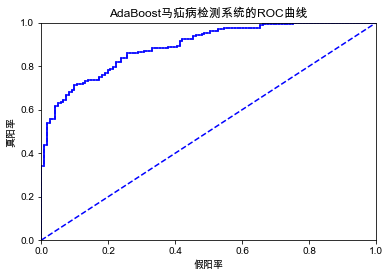

In [21]:
dataArr, LabelArr = loadDataSet('horseColicTraining2.txt')
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, LabelArr)
plotROC(aggClassEst.T, LabelArr)